### IMPORT NECESSARY LIBRARIES

In [87]:
import pandas as pd
import numpy as np
import docx
import glob
import warnings
warnings.filterwarnings("ignore")
import spacy
import pickle
import random

from spacy import displacy
import docx
import spacy
from spacy import schemas
from spacy import Dict
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import textract
import antiword
import re
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
from spacy.matcher import Matcher
#nltk.download('stopwords')
#nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nlp = spacy.load("en_core_web_trf")

### IMPORT DATASETS

In [88]:
data1 = pd.read_csv("D:\EXCLER solution\Project Files\DS Project Resume NLP\CSV FILES of Resumes\intership_resumes.csv")
data2 = pd.read_csv("D:\EXCLER solution\Project Files\DS Project Resume NLP\CSV FILES of Resumes\Peoplesoft_Resumes.csv")
data3 = pd.read_csv("D:\EXCLER solution\Project Files\DS Project Resume NLP\CSV FILES of Resumes\React_Developer_resumes.csv")
data4 = pd.read_csv("D:\EXCLER solution\Project Files\DS Project Resume NLP\CSV FILES of Resumes\SQLDeveloperLightning_Resumes.csv")
data5 = pd.read_csv("D:\EXCLER solution\Project Files\DS Project Resume NLP\CSV FILES of Resumes\workday_resumes.csv")

In [89]:
Resume = pd.concat([data1,data2,data3,data4,data5],axis=0)
Resume = Resume.reset_index()
Resume = Resume.drop(columns='Number',axis=0)
Resume = Resume.drop(columns='index',axis=0)
Resume

,Label,CV
0,Internship,Name: Ravali P Curriculum Vitae Specialization...
1,Internship,SUSOVAN BAG Seeking a challenging position in ...
2,Peoplesoft,Anubhav Kumar Singh To work in a globally comp...
3,Peoplesoft,Profile Summary: 7+ years of experience in imp...
4,Peoplesoft,PeopleSoft Database Administrator Gangareddy P...
...,...,...
74,workdayResumes,Workday Integration Consultant Name : Sri Kris...
75,workdayResumes,SRIKANTH (WORKDAY HCM CONSULTANT) Seeking suit...
76,workdayResumes,WORKDAY | HCM | FCM Name : Kumar S.S Role : Wo...
77,workdayResumes,Venkateswarlu.B Workday Consultant Having 5.3 ...


### Exploratory Data Analysis (EDA)

In [90]:
Resume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   79 non-null     object
 1   CV      79 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


In [91]:
Resume.isnull().sum()

Label    0
CV       0
dtype: int64

### Calculating each Characterstic in dataframe BEFORE CLEANING 

In [92]:
before_characters=Resume["CV"].apply(len)
before_characters

0     2114
1     1310
2     6967
3     7271
4     5908
      ... 
74    6512
75    6156
76    7205
77    2610
78    4919
Name: CV, Length: 79, dtype: int64

In [93]:
print('Total Number of characters before cleaning dataset :',before_characters.sum())
print('Mean of each characters before cleaning the dataset:',before_characters.mean())
print('Median of characters before cleaning the dataset:',before_characters.median())
print('Standard Deviation of characters before cleaning the dataset:',before_characters.std())
print('skew of characters before cleaning the dataset:',before_characters.skew())

Total Number of characters before cleaning dataset : 362913
Mean of each characters before cleaning the dataset: 4593.835443037975
Median of characters before cleaning the dataset: 3696.0
Standard Deviation of characters before cleaning the dataset: 3021.5634619556013
skew of characters before cleaning the dataset: 1.8420390755120162


### Calculating each WORD Characterstic in dataframe BEFORE cleaning

In [94]:
before_words = Resume['CV'].apply(lambda x: len(str(x).split(' ')))
before_words

0      280
1      184
2      934
3      987
4      786
      ... 
74     889
75     878
76    1027
77     352
78     681
Name: CV, Length: 79, dtype: int64

In [95]:
print('Total Number of Word in dataset before cleaning:',before_words.sum())
print('Mean of each Word in dataset before cleaning:',before_words.mean())
print('Median of Word in dataset before cleaning:',before_words.median())
print('Standard Deviation of Word in dataset before cleaning:',before_words.std())
print('skew of Word dataset before cleaning:',before_words.skew())

Total Number of Word in dataset before cleaning: 51305
Mean of each Word in dataset before cleaning: 649.4303797468355
Median of Word in dataset before cleaning: 514.0
Standard Deviation of Word in dataset before cleaning: 422.97516698471946
skew of Word dataset before cleaning: 1.8389509436825116


### Data Preprocessing

##### We will perform label encoding to convert category variable from string datatype to float datatype

In [96]:
from sklearn.preprocessing import LabelEncoder
le_encoder = LabelEncoder()
Resume["Encoded_Skill"] = le_encoder.fit_transform(Resume["Label"])
Resume.head()

,Label,CV,Encoded_Skill
0,Internship,Name: Ravali P Curriculum Vitae Specialization...,0
1,Internship,SUSOVAN BAG Seeking a challenging position in ...,0
2,Peoplesoft,Anubhav Kumar Singh To work in a globally comp...,1
3,Peoplesoft,Profile Summary: 7+ years of experience in imp...,1
4,Peoplesoft,PeopleSoft Database Administrator Gangareddy P...,1


In [97]:
Resume.Label.value_counts()

ReactDeveloper    22
workdayResumes    21
Peoplesoft        20
SQLDeveloper      14
Internship         2
Name: Label, dtype: int64

In [98]:
print("Displaying the distinct categories of resume -")
print(Resume.Label.unique())

Displaying the distinct categories of resume -
['Internship' 'Peoplesoft' 'ReactDeveloper' 'SQLDeveloper'
 'workdayResumes']


### Data Cleaning

In [99]:
import re #REGULAR EXPRESSION
import string

def clean_text(CV):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    CV = CV.lower()
    CV = re.sub('\[.*?\]', '', CV)
    CV = re.sub('[%s]' % re.escape(string.punctuation), '', CV)
    CV = re.sub('\w*\d\w*', '', CV)
    CV = re.sub("[0-9" "]+"," ",CV)
    CV = re.sub('[‘’“”…]', '', CV)
    return CV

clean = lambda x: clean_text(x)

In [100]:
Resume['CV'] = Resume.CV.apply(clean)
Resume.CV

0     name ravali p curriculum vitae specialization ...
1     susovan bag seeking a challenging position in ...
2     anubhav kumar singh to work in a globally comp...
3     profile summary  years of experience in implem...
4     peoplesoft database administrator gangareddy p...
                            ...                        
74    workday integration consultant name  sri krish...
75    srikanth workday hcm consultant seeking suitab...
76    workday  hcm  fcm name  kumar ss role  workday...
77    venkateswarlub workday consultant having  year...
78    vinay kumar v workday functional consultant ex...
Name: CV, Length: 79, dtype: object

### Word frequency BEFORE removal of STOPWORDS

In [101]:
#Word Frequency
frequency = pd.Series(' '.join(Resume['CV']).split()).value_counts()[:20] #For top 20
frequency

and            2696
the            1329
in             1244
to             1048
of              961
for             636
on              625
experience      572
with            410
as              391
peoplesoft      386
application     378
using           375
workday         368
server          317
a               307
from            296
reports         295
data            285
project         265
dtype: int64

### Removing STOPWORDS

In [102]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
Resume['CV'] = Resume['CV'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

### Word frequency AFTER removal of STOPWORDS

In [103]:
frequency_Sw = pd.Series(' '.join(Resume['CV']).split()).value_counts()[:20] # for top 20
frequency_Sw

experience      572
peoplesoft      386
application     378
using           375
workday         368
server          317
reports         295
data            285
project         265
business        250
process         220
database        217
web             214
knowledge       201
sql             196
worked          195
involved        184
integrations    175
like            169
integration     167
dtype: int64

### Performing A NER (Using Spacy)

In [104]:
nlp = spacy.load("en_core_web_trf")
text=nlp(Resume["CV"][0])
displacy.render(text, style = "ent")

#### First take a look at the number of Characters present in each sentence. This can give us a rough idea about the resume length

##### Calculating each Characterstic in dataframe

In [105]:
characters=Resume["CV"].apply(len)
characters

0     1784
1     1078
2     5804
3     5931
4     4795
      ... 
74    5516
75    5146
76    6046
77    2154
78    4131
Name: CV, Length: 79, dtype: int64

In [106]:
print('Total Number of characters dataset:',characters.sum())
print('Mean of each characters in datset:',characters.mean())
print('Median of characters in dataset:',characters.median())
print('Standard Deviation of characters in dataset:',characters.std())
print('skew of characters dataset:',characters.skew())

Total Number of characters dataset: 295942
Mean of each characters in datset: 3746.1012658227846
Median of characters in dataset: 3015.0
Standard Deviation of characters in dataset: 2487.3184489600117
skew of characters dataset: 1.7826848176246577


<AxesSubplot:ylabel='Density'>

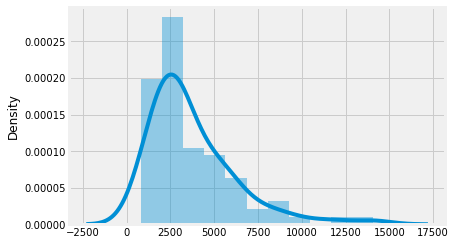

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(x = characters)

#### Calculating each Word Characterstic in dataframe

In [108]:
words = Resume['CV'].apply(lambda x: len(str(x).split(' ')))
words

0     207
1     130
2     685
3     707
4     553
     ... 
74    658
75    644
76    768
77    259
78    500
Name: CV, Length: 79, dtype: int64

In [109]:
print('Total Number of Word in dataset:',words.sum())
print('Mean of each Word in datset:',words.mean())
print('Median of Word in dataset:',words.median())
print('Standard Deviation of Word in dataset:',words.std())
print('skew of Word dataset:',words.skew())

Total Number of Word in dataset: 36185
Mean of each Word in datset: 458.0379746835443
Median of Word in dataset: 380.0
Standard Deviation of Word in dataset: 295.5711308826187
skew of Word dataset: 1.6889132345848146


<AxesSubplot:ylabel='Density'>

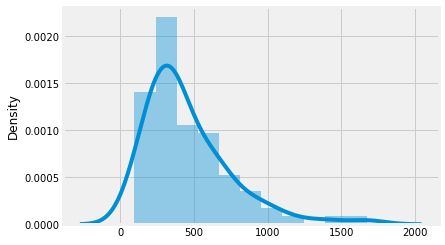

In [110]:
sns.distplot(x = words)

### VISUALIZATION OF DATASET

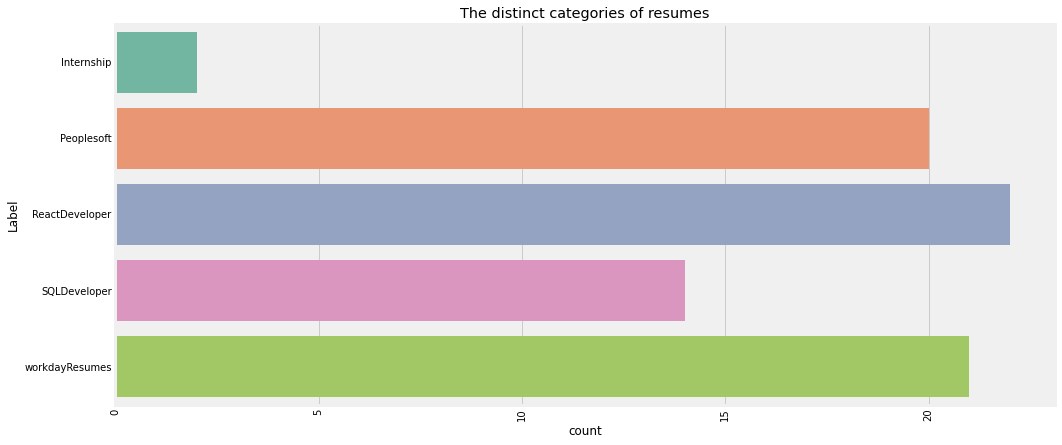

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
plt.figure(figsize=(15,7))
plt.title("The distinct categories of resumes")
plt.xticks(rotation=90)
sns.countplot(y="Label", data=Resume,palette=("Set2"))
plt.show()

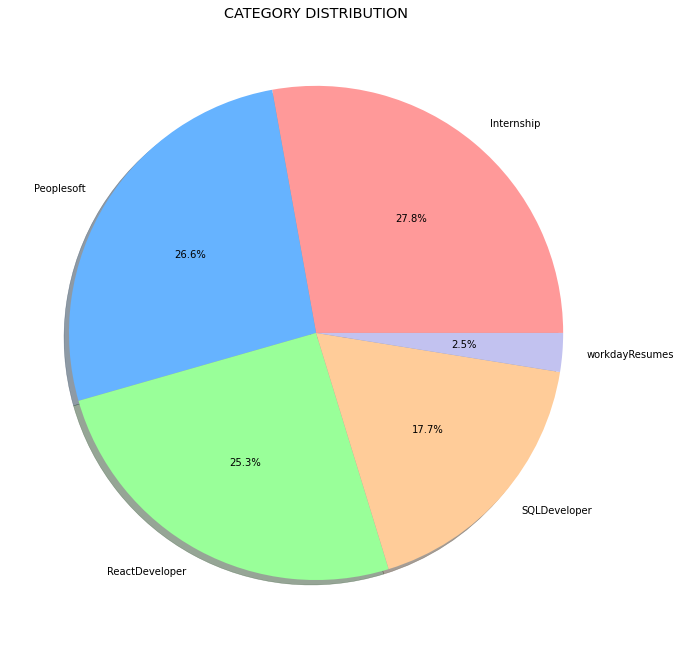

In [112]:
from matplotlib.gridspec import GridSpec
targetCounts = Resume.Label.value_counts()
targetLabels  = Resume.Label.unique()
# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('plasma')
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')


source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

#### Feature Extraction

In [113]:
from collections import Counter
import seaborn as sns

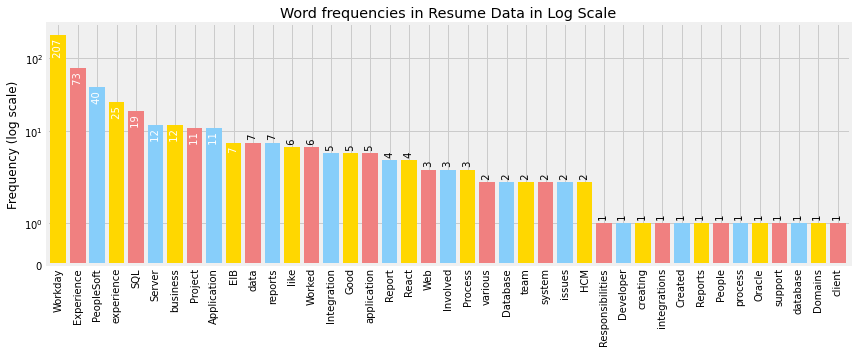

In [114]:
words =['using','Workday','Experience','PeopleSoft',
 'experience','SQL','Application','data','Server',
 'business','Project','reports','like','HCM','Worked',
 'knowledge','Involved','various','Good', 'Reports','React','EIB','integrations','Web','system','creating','issues',
 'Created', 'Responsibilities','Process','process','support', 
 'application','new','People','I','team','working', 
 'Database','database','Integration','Domains','client', 
 'requirements','Core',  'Business', 
'Oracle','Report', 'Developer', 'Data']
indices = np.random.zipf(1.6, size=500).astype(np.int) % len(words)
tw = np.array(words)[indices]

tf = Counter(tw)

y = [count for tag, count in tf.most_common(50)]
x = [tag for tag, count in tf.most_common(50)]
plt.style.use('seaborn-dark-palette')
plt.figure(figsize=(12,5))
plt.bar(x, y, color=['gold','lightcoral', 'lightskyblue'])
plt.title("Word frequencies in Resume Data in Log Scale")
plt.ylabel("Frequency (log scale)")
plt.yscale('symlog') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(50)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

In [115]:
def wordBarGraphFunction_1(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.style.use('fivethirtyeight')
    sns.barplot(x=np.arange(20),y= [word_count_dict[w] for w in reversed(popular_words_nonstop[0:20])])
    plt.xticks([x + 0.5 for x in range(20)], reversed(popular_words_nonstop[0:20]),rotation=90)
    plt.title(title)
    plt.show()

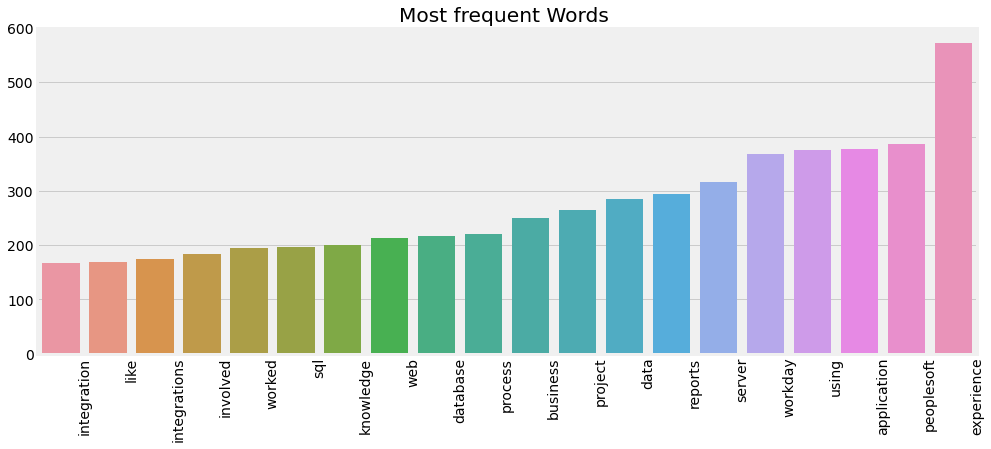

In [116]:
plt.figure(figsize=(15,6))
wordBarGraphFunction_1(Resume,"CV","Most frequent Words ")

#### WORDCLOUD

In [117]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

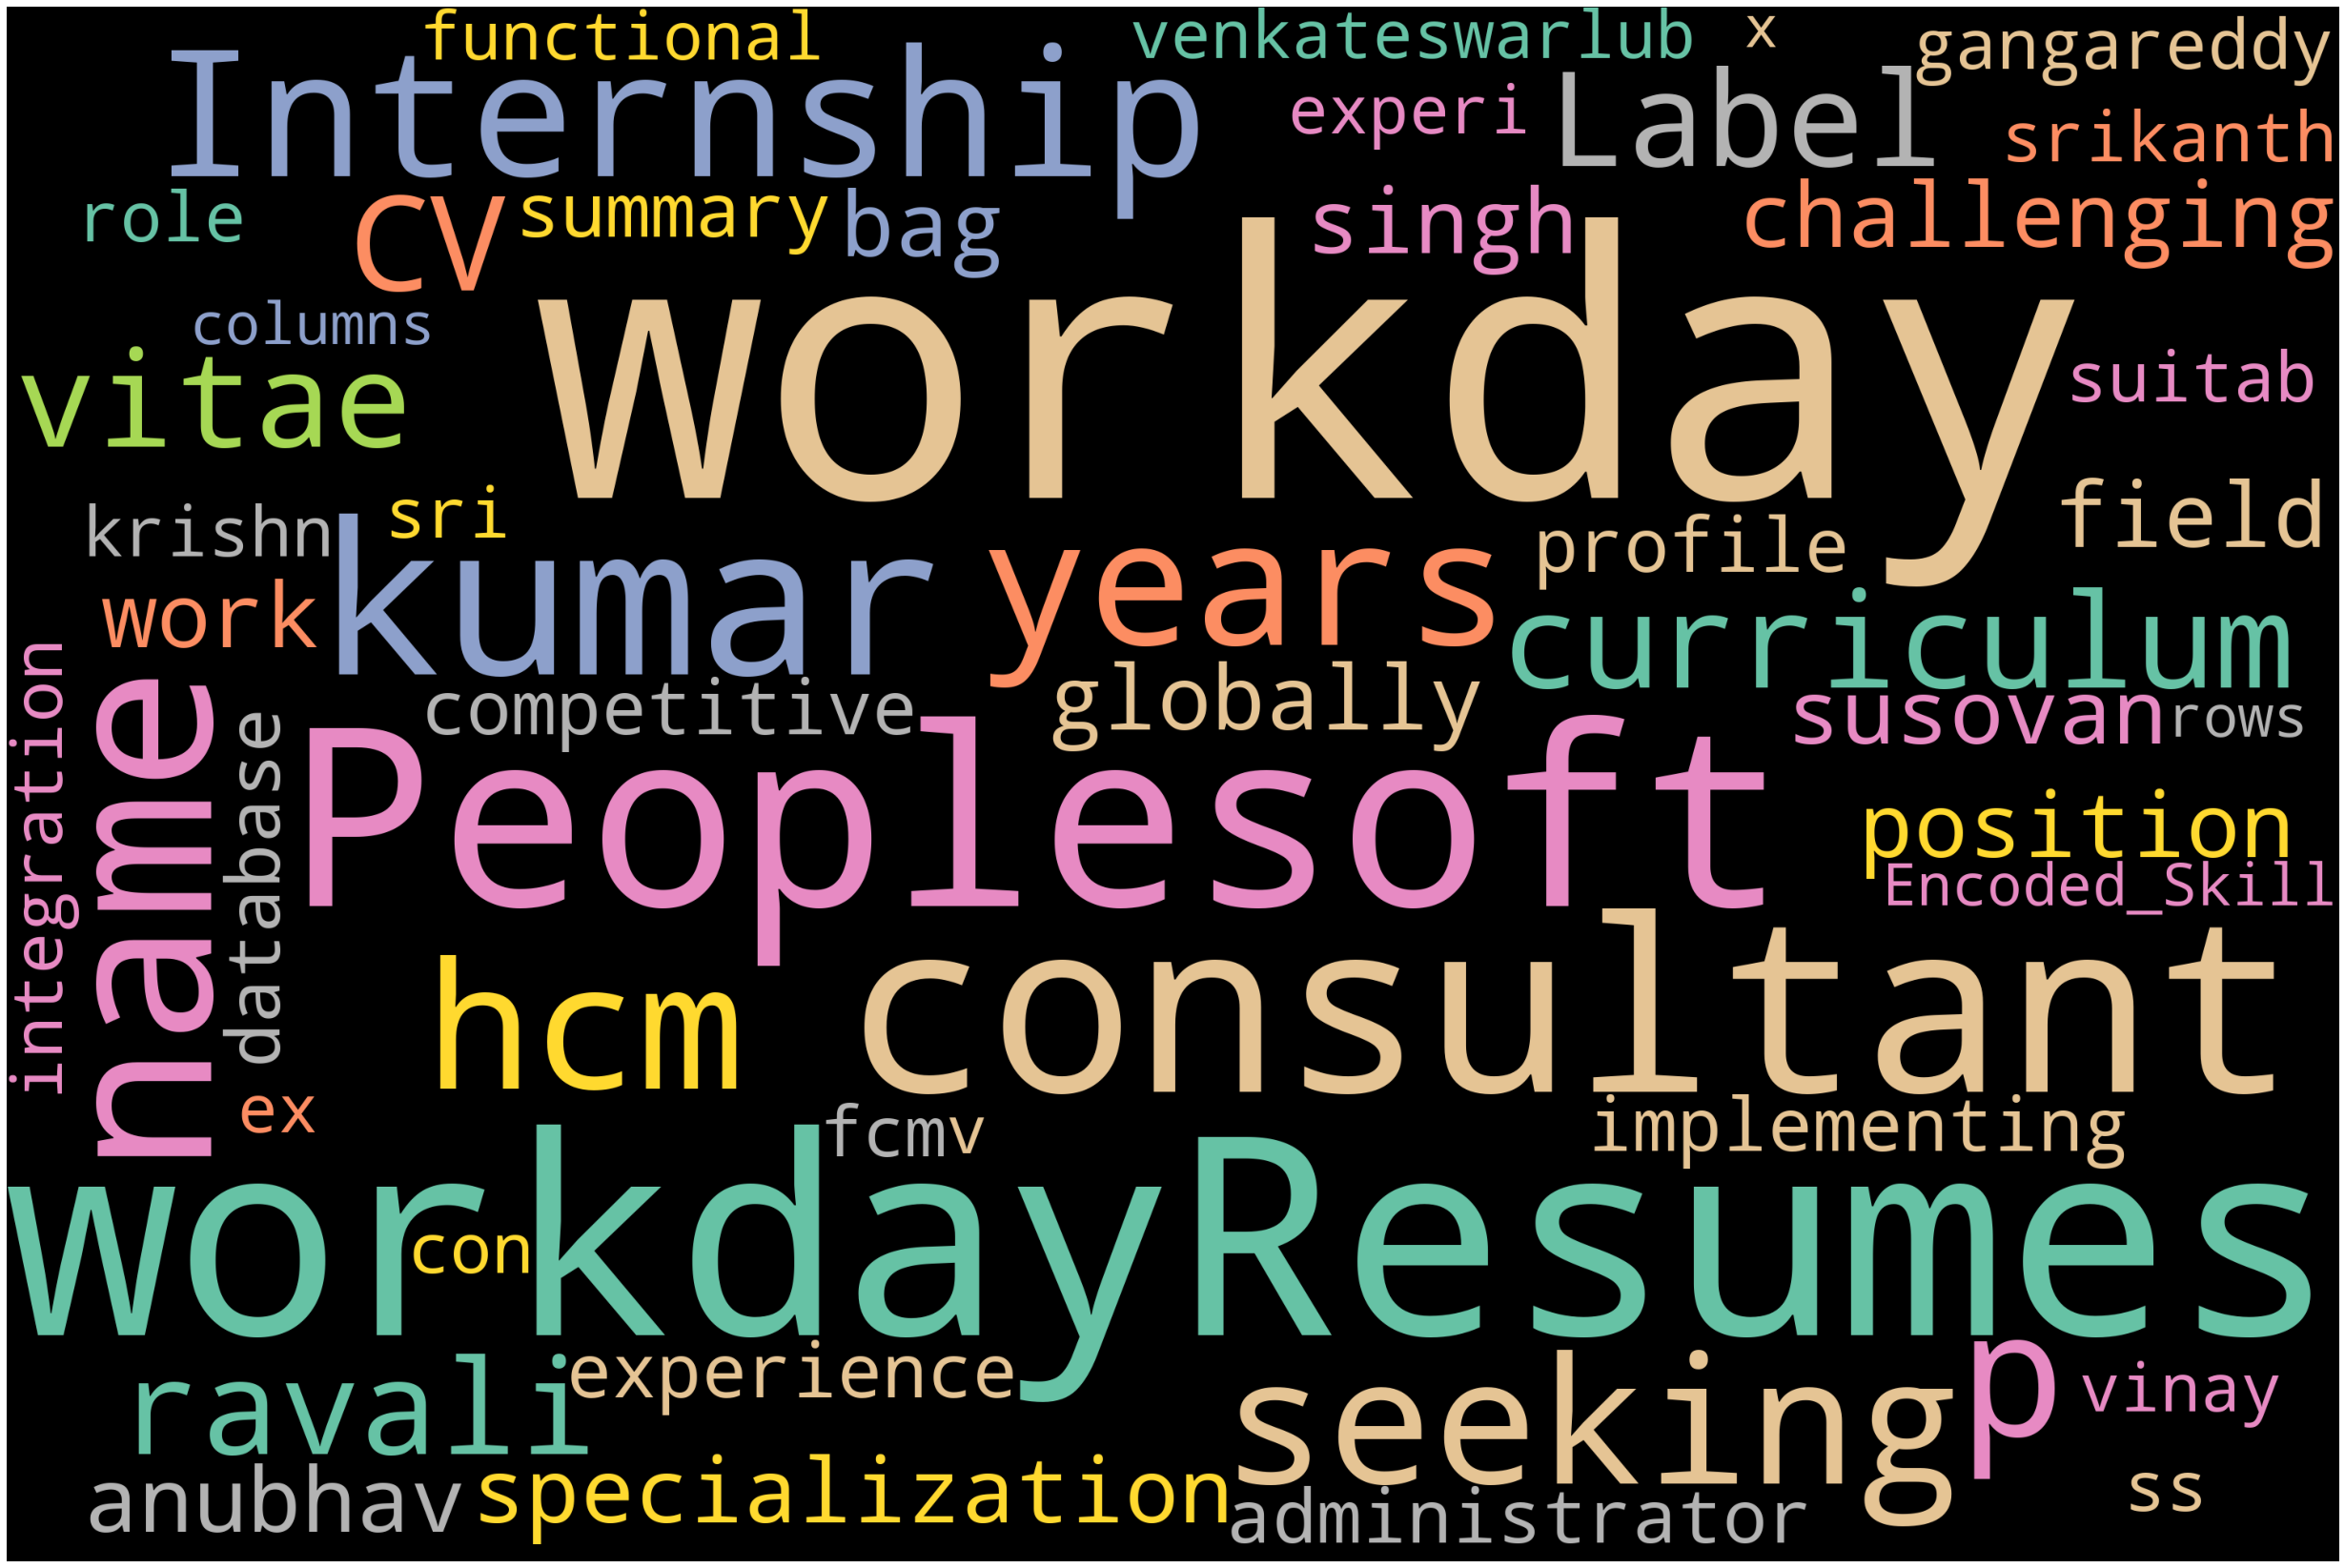

In [118]:
# Generate wordcloud
stopwords = STOPWORDS
stopwords.add('will')
wordcloud = WordCloud(width = 3000, height = 2000, background_color='black', max_words=100,colormap='Set2',stopwords=stopwords).generate(str(Resume))
# Plot
plot_cloud(wordcloud)

#### Bag Of Words

In [119]:
requiredText = Resume["CV"]
requiredTarget = Resume["Encoded_Skill"].values
Countvectorizer=CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',stop_words = 'english')
bag = Countvectorizer.fit_transform(requiredText)
Countvectorizer.vocabulary_

{'ravali': 3137,
 'p': 2706,
 'curriculum': 914,
 'vitae': 4200,
 'specialization': 3623,
 'computer': 722,
 'science': 3417,
 'engg': 1270,
 'utilize': 4118,
 'technical': 3870,
 'skills': 3570,
 'achieving': 39,
 'target': 3844,
 'developing': 1075,
 'best': 394,
 'performance': 2795,
 'organization': 2667,
 'manual': 2292,
 'testing': 3909,
 'strong': 3738,
 'knowledge': 2107,
 'sdlc': 3435,
 'concepts': 727,
 'extensive': 1386,
 'white': 4262,
 'box': 448,
 'good': 1609,
 'functional': 1537,
 'integration': 1952,
 'extreme': 1393,
 'adhoc': 72,
 'reliability': 3225,
 'exploratory': 1375,
 'stlc': 3716,
 'test': 3905,
 'cases': 545,
 'scenarios': 3401,
 'globalization': 1595,
 'compatibility': 700,
 'regression': 3211,
 'plan': 2846,
 'agile': 108,
 'methdology': 2374,
 'scrum': 3434,
 'methodology': 2378,
 'expertise': 1371,
 'sprint': 3645,
 'planning': 2848,
 'meeting': 2356,
 'retrospective': 3312,
 'product': 2983,
 'backlog': 340,
 'bug': 479,
 'triage': 4018,
 'normalization'

#### VECTORIZATION

#### COUNT VECTORIZER tells the frequency of a word.

In [120]:
vectorizer1 = CountVectorizer(min_df = 1, max_df = 0.9)
count_vect = vectorizer1.fit_transform(Resume["CV"])
word_freq_df = pd.DataFrame({'term': vectorizer1.get_feature_names(), 'occurrences':np.asarray(count_vect.sum(axis=0)).ravel().tolist()})
word_freq_df['frequency'] = word_freq_df['occurrences']/np.sum(word_freq_df['occurrences'])
word_freq_df

,term,occurrences,frequency
0,aa,1,0.000028
1,abdul,2,0.000057
2,abilities,4,0.000114
3,abilitiescommunication,1,0.000028
4,ability,37,0.001053
...,...,...,...
4428,òpaper,1,0.000028
4429,òposter,1,0.000028
4430,ôbroadband,1,0.000028
4431,þnding,1,0.000028


<AxesSubplot:ylabel='Density'>

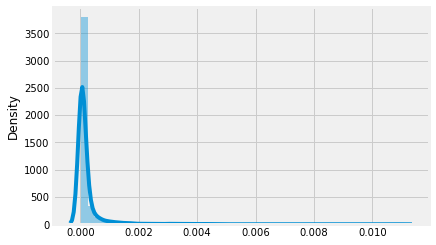

In [121]:
sns.distplot(x =[word_freq_df['frequency']])

#### TFIDF - Term frequency inverse Document Frequency

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [123]:
word_vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english',max_features=1500)
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

### Model Building || Model Training || Model Evaluation

#### DATA PREPARATION

In [124]:
x_train,x_test,y_train,y_test = train_test_split(WordFeatures, requiredTarget, random_state=0, test_size=0.2)
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("x Test shape:",x_test.shape)
print("y Test shape:",y_test.shape)


X Train shape: (63, 1500)
Y Train shape: (63,)
x Test shape: (16, 1500)
y Test shape: (16,)


### 1. LOGISTIC REGRESSION

In [125]:
#IMPORTING NECESSARY LIBRARIES FOR LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report

In [126]:
logistic_classifier = LogisticRegression()
logistic_classifier.fit(x_train,y_train)

#Predicting on Training Data
pred_train_log = logistic_classifier.predict(x_train)
#Accuracy On Train Data
train_acc_log = np.mean(pred_train_log==y_train)
print("ACCURACY OF TRAIN DATA IN LOGISTIC REGRESSION:", train_acc_log)

#Predicting on Test Data
pred_test_log = logistic_classifier.predict(x_test)
#Accuracy On Test Data
test_acc_log = np.mean(pred_test_log==y_test)
print("ACCURACY OF TEST DATA IN LOGISTIC REGRESSION:",test_acc_log )

#Confusion Matrix
logistic_cm = confusion_matrix(y_test,pred_test_log)

#Classification Report
print("CLASSIFICATION REPORT OF LOGISTIC REGRESSION:\n", classification_report(y_test,pred_test_log))

ACCURACY OF TRAIN DATA IN LOGISTIC REGRESSION: 0.9682539682539683
ACCURACY OF TEST DATA IN LOGISTIC REGRESSION: 0.9375
CLASSIFICATION REPORT OF LOGISTIC REGRESSION:
               precision    recall  f1-score   support

           1       0.50      1.00      0.67         1
           2       1.00      1.00      1.00         4
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         6

    accuracy                           0.94        16
   macro avg       0.88      0.95      0.89        16
weighted avg       0.97      0.94      0.94        16



In [127]:
accuracy_log = round(accuracy_score(y_test,pred_test_log),4)
precision_log = round(precision_score(y_test,pred_test_log,average = 'macro'),4)
recall_log = round(recall_score(y_test,pred_test_log,average = 'macro'),4)
f1_log = round(f1_score(y_test,pred_test_log,average = 'macro'),4)

#Printing Accuracy, Recall, precision, F1_score
print('Accuracy Score   : ',accuracy_log )
print('Precision Score  : ',precision_log )
print('Recall Score     : ', recall_log)
print('f1-Score         : ',f1_log )

Accuracy Score   :  0.9375
Precision Score  :  0.875
Recall Score     :  0.95
f1-Score         :  0.8889


### 2. DECISION TREE

In [128]:
#IMPORTING NECESSARY LIBRARIES FOR DECISION TREE
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [129]:
DT = DecisionTreeClassifier()
DT_classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth=2)
DT_classifier.fit(x_train,y_train)

#Predicting on Train Data
pred_train_dt = DT_classifier.predict(x_train)
#Accuracy On Train Data
train_acc_dt = np.mean(pred_train_dt==y_train)
print("ACCURACY OF TRAIN DATA IN DECISION TREE:",train_acc_dt )

#Predicting on Test Data
pred_test_dt = DT_classifier.predict(x_test)
#Accuracy on Test Data
test_acc_dt = np.mean(pred_test_dt==y_test)
print("ACCURACY OF TEST DATA IN DECISION TREE:",test_acc_dt )

#Confusion Matrix
dt_cm = confusion_matrix(y_test,pred_test_dt)

#Classification Report
print("CLASSIFICATION REPORT OF DECISION TREE:\n", classification_report(y_test,pred_test_dt))

ACCURACY OF TRAIN DATA IN DECISION TREE: 0.8253968253968254
ACCURACY OF TEST DATA IN DECISION TREE: 0.6875
CLASSIFICATION REPORT OF DECISION TREE:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.44      1.00      0.62         4
           3       0.00      0.00      0.00         5
           4       1.00      1.00      1.00         6

    accuracy                           0.69        16
   macro avg       0.61      0.75      0.65        16
weighted avg       0.55      0.69      0.59        16



In [130]:
accuracy_dt = round(accuracy_score(y_test,pred_test_dt),4)
precision_dt = round(precision_score(y_test,pred_test_dt,average = 'macro'),4)
recall_dt = round(recall_score(y_test,pred_test_dt,average = 'macro'),4)
f1_dt = round(f1_score(y_test,pred_test_dt,average = 'macro'),4)

#Printing Accuracy, Recall, precision, F1_score
print('Accuracy Score   : ',accuracy_dt )
print('Precision Score  : ',precision_dt )
print('Recall Score     : ', recall_dt)
print('f1-Score         : ',f1_dt )

Accuracy Score   :  0.6875
Precision Score  :  0.6111
Recall Score     :  0.75
f1-Score         :  0.6538


### 3. RANDOM FOREST 

In [131]:
#IMPORTING NECESSARY LIBRARIES FOR RANDOM FOREST
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [132]:
RF = {'n_estimators':15,'class_weight': "balanced",'n_jobs':-1,'random_state':42}
RF_classifier = RandomForestClassifier(**RF)
RF_classifier.fit(x_train,y_train)

#Predicting on Train Data
pred_train_rf = RF_classifier.predict(x_train)
#Accuracy On Train Data
train_acc_rf = np.mean(pred_train_rf==y_train)
print("ACCURACY OF TRAIN DATA IN RANDOM FOREST:",train_acc_rf)

#Predicting on Test Data
pred_test_rf = RF_classifier.predict(x_test)
#Accuracy On Test Data
test_acc_rf = np.mean(pred_test_rf==y_test)
print("ACCURACY OF TEST DATA IN RANDOM FOREST:",test_acc_rf )

#Confusion Matrix
rf_cm = confusion_matrix(y_test,pred_test_rf)

#Classification Report
print("CLASSIFICATION REPORT OF RANDOM FOREST:\n", classification_report(y_test,pred_test_rf))

ACCURACY OF TRAIN DATA IN RANDOM FOREST: 1.0
ACCURACY OF TEST DATA IN RANDOM FOREST: 1.0
CLASSIFICATION REPORT OF RANDOM FOREST:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         6

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [133]:
accuracy_rf = round(accuracy_score(y_test,pred_test_rf),4)
precision_rf = round(precision_score(y_test,pred_test_rf,average = 'macro'),4)
recall_rf = round(recall_score(y_test,pred_test_rf,average = 'macro'),4)
f1_rf = round(f1_score(y_test,pred_test_rf,average = 'macro'),4)

#Printing Accuracy, Recall, precision, F1_score
print('Accuracy Score   : ',accuracy_rf )
print('Precision Score  : ',precision_rf )
print('Recall Score     : ', recall_rf)
print('f1-Score         : ',f1_rf )

Accuracy Score   :  1.0
Precision Score  :  1.0
Recall Score     :  1.0
f1-Score         :  1.0


### 4. MULTINOMIAL NAVIE BAYES

In [134]:
#IMPORTING NECESSARY LIBRARIES FOR MULTINOMIAL NAVIE BAYES
from sklearn.naive_bayes import MultinomialNB as MB

In [135]:
classifier_mb = MB()
classifier_mb.fit(x_train,y_train)

#Predicting On Train Data
pred_train_mb = classifier_mb.predict(x_train)
#Accuracy On Train Data
train_acc_mb = np.mean(pred_train_mb==y_train)
print("ACCURACY OF TRAIN DATA IN MULTINOMIAL NAVIE BAYES:", train_acc_mb)

#Predicting On Test Data
pred_test_mb = classifier_mb.predict(x_test)
#Accuracy On Test Data
test_acc_mb = np.mean(pred_test_mb==y_test)
print("ACCURACY OF TEST DATA IN MULTINOMIAL NAVIE BAYES:", test_acc_mb)

#Confusion Matrix
mb_cm = confusion_matrix(y_test,pred_test_mb)

#Classification Report
print("CLASSIFICATION REPORT OF MULTINOMIAL NAVIE BAYES:\n", classification_report(y_test,pred_test_mb))

ACCURACY OF TRAIN DATA IN MULTINOMIAL NAVIE BAYES: 0.9682539682539683
ACCURACY OF TEST DATA IN MULTINOMIAL NAVIE BAYES: 0.875
CLASSIFICATION REPORT OF MULTINOMIAL NAVIE BAYES:
               precision    recall  f1-score   support

           1       0.50      1.00      0.67         1
           2       0.80      1.00      0.89         4
           3       1.00      0.60      0.75         5
           4       1.00      1.00      1.00         6

    accuracy                           0.88        16
   macro avg       0.82      0.90      0.83        16
weighted avg       0.92      0.88      0.87        16



In [136]:
accuracy_mb = round(accuracy_score(y_test,pred_test_mb),4)
precision_mb = round(precision_score(y_test,pred_test_mb,average = 'macro'),4)
recall_mb = round(recall_score(y_test,pred_test_mb,average = 'macro'),4)
f1_mb = round(f1_score(y_test,pred_test_mb,average = 'macro'),4)

#Printing Accuracy, Recall, precision, F1_score
print('Accuracy Score   : ',accuracy_mb )
print('Precision Score  : ',precision_mb )
print('Recall Score     : ', recall_mb)
print('f1-Score         : ',f1_mb )

Accuracy Score   :  0.875
Precision Score  :  0.825
Recall Score     :  0.9
f1-Score         :  0.8264


### 5. SUPPORT VECTOR MACHINE 

In [137]:
##IMPORTING NECESSARY LIBRARIES FOR SUPPORT VECTOR MACHINE
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [138]:
svm_classifier = (SVC(kernel='linear'))
svm_classifier.fit(x_train,y_train)

#Predicting On Train Data
pred_train_svm = svm_classifier.predict(x_train)
#Accuracy On Train Data
train_acc_svm = np.mean(pred_train_svm==y_train)
print("ACCURACY OF TRAIN DATA IN SUPPORT VECTOR MACHINE:",train_acc_svm )

#Prediciting On Test Data
pred_test_svm = svm_classifier.predict(x_test)
#Accuracy On Test Data
test_acc_svm = np.mean(pred_test_svm==y_test)
print("ACCURACY OF TEST DATA IN SUPPORT VECTOR MACHINE:",test_acc_svm)

#Confusion Matrix
svm_cm = confusion_matrix(y_test,pred_test_svm)

#Classification Report
print("CLASSIFICATION REPORT OF SUPPORT VECTOR MACHINE:\n", classification_report(y_test,pred_test_svm))

ACCURACY OF TRAIN DATA IN SUPPORT VECTOR MACHINE: 1.0
ACCURACY OF TEST DATA IN SUPPORT VECTOR MACHINE: 1.0
CLASSIFICATION REPORT OF SUPPORT VECTOR MACHINE:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         6

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [139]:
accuracy_svm = round(accuracy_score(y_test,pred_test_svm),4)
precision_svm = round(precision_score(y_test,pred_test_svm,average = 'macro'),4)
recall_svm = round(recall_score(y_test,pred_test_svm,average = 'macro'),4)
f1_svm = round(f1_score(y_test,pred_test_svm,average = 'macro'),4)

#Printing Accuracy, Recall, precision, F1_score
print('Accuracy Score   : ',accuracy_svm )
print('Precision Score  : ',precision_svm )
print('Recall Score     : ', recall_svm)
print('f1-Score         : ',f1_svm )

Accuracy Score   :  1.0
Precision Score  :  1.0
Recall Score     :  1.0
f1-Score         :  1.0


### CONFUSION MATRIX

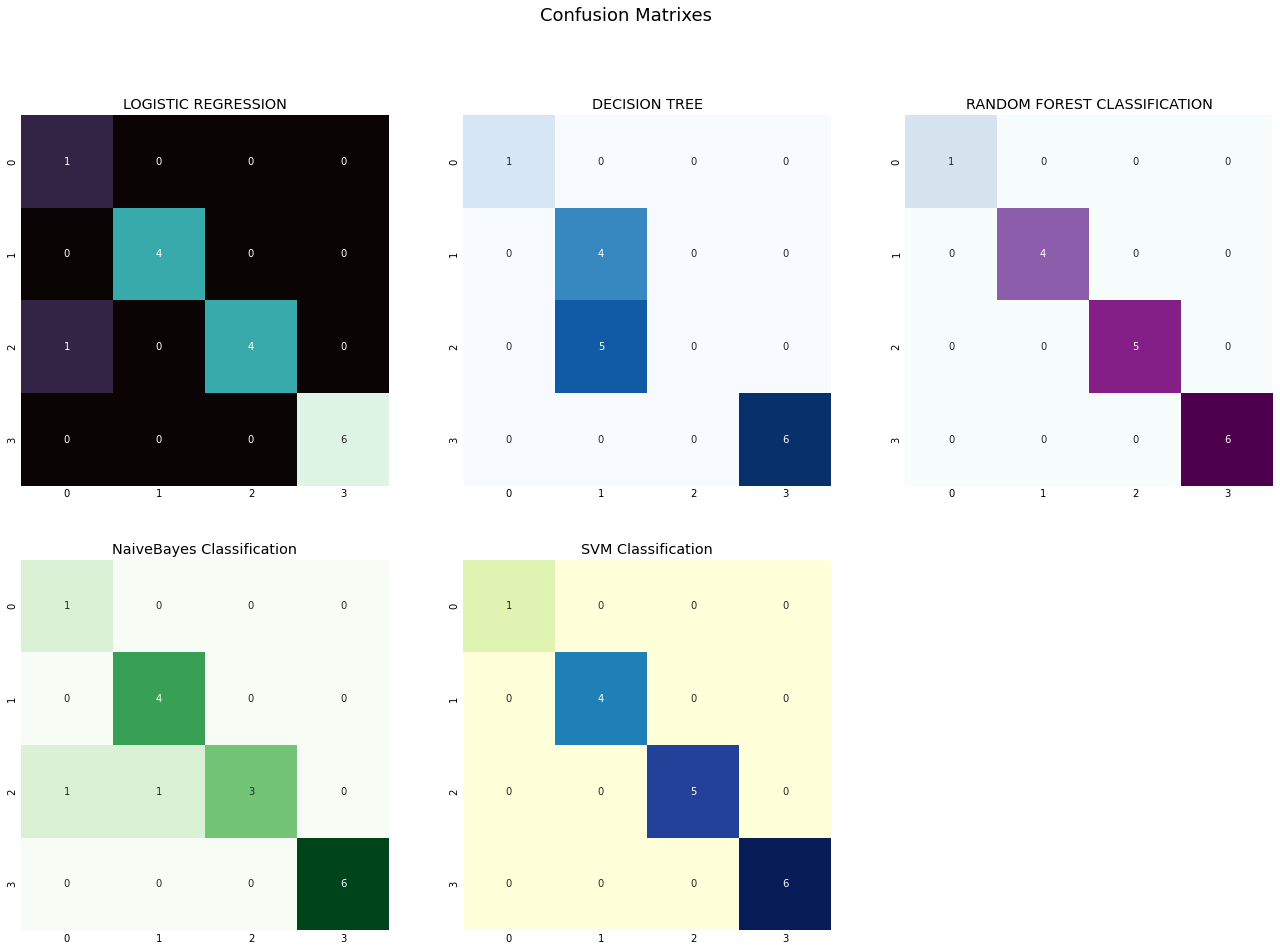

In [140]:
plt.figure(figsize=(20,15))

plt.suptitle("Confusion Matrixes", fontsize=18)

plt.subplot(2,3,1)
plt.title("LOGISTIC REGRESSION")
sns.heatmap(logistic_cm, cbar=False, annot=True, cmap="mako",  fmt="d")

plt.subplot(2,3,2)
plt.title("DECISION TREE")
sns.heatmap(dt_cm, cbar=False, annot=True, cmap="Blues", fmt="d")

plt.subplot(2,3,3)
plt.title("RANDOM FOREST CLASSIFICATION")
sns.heatmap(rf_cm, cbar=False, annot=True, cmap="BuPu", fmt="d")

plt.subplot(2,3,4)
plt.title("NaiveBayes Classification")
sns.heatmap(mb_cm, cbar=False, annot=True, cmap="Greens", fmt="d")

plt.subplot(2,3,5)
plt.title("SVM Classification")
sns.heatmap(svm_cm, cbar=False, annot=True, cmap="YlGnBu",  fmt="d")

plt.show()

In [141]:
table = {'Classifier' : ['LOGISTIC REGRESSION', 'DECISION TREE', 'RANDOM FOREST', 'MULTINOMIAL NAIVE BAYES', 'SUPPORT VECTOR MACHINE'], 'Accuracy_Score' : [accuracy_log, accuracy_dt, accuracy_rf, accuracy_mb, accuracy_svm], 'Precision_Score' : [precision_log, precision_dt, precision_rf, precision_mb, precision_svm], 'Recall_Score' : [recall_log, recall_dt, recall_rf, recall_mb, recall_svm], 'F1-Score' : [f1_log, f1_dt, f1_rf, f1_mb, f1_svm]}
table = pd.DataFrame(table)
table


,Classifier,Accuracy_Score,Precision_Score,Recall_Score,F1-Score
0,LOGISTIC REGRESSION,0.9375,0.8750,0.95,0.8889
1,DECISION TREE,0.6875,0.6111,0.75,0.6538
2,RANDOM FOREST,1.0000,1.0000,1.00,1.0000
3,MULTINOMIAL NAIVE BAYES,0.8750,0.8250,0.90,0.8264
4,SUPPORT VECTOR MACHINE,1.0000,1.0000,1.00,1.0000


### ACCURACY COMPARISON PLOT

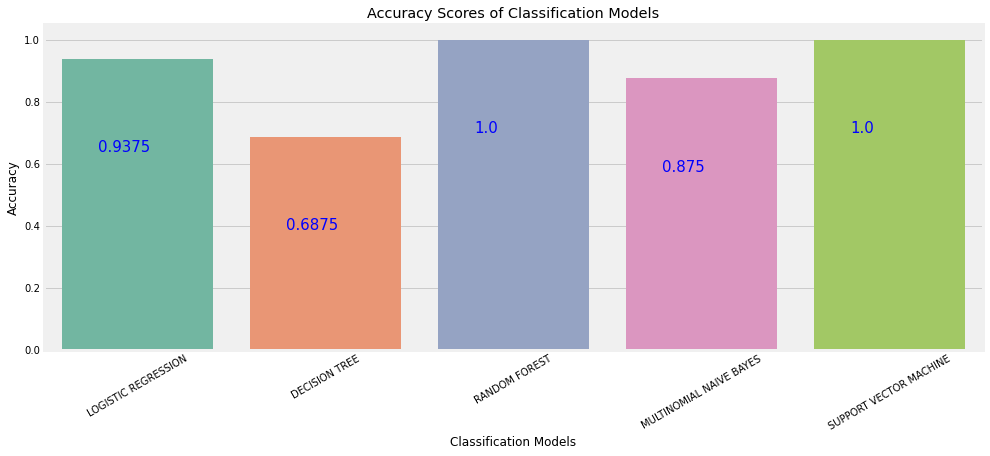

In [142]:
#Accuracy
plt.figure(figsize=(15,6))
ax= sns.barplot(x=table.Classifier, y=table.Accuracy_Score, palette =sns.color_palette("Set2") )
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.xlabel('Classification Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores of Classification Models')
for i in ax.patches:
    ax.text(i.get_x()+.19, i.get_height()-0.3, \
            str(round((i.get_height()), 4)), fontsize=15, color='b')
plt.show()

### FINALIZING MODEL

#### We finalize RANDOM FOREST as it gives 100% Accuracy. Random Forest fits the model in Resume Classification.

#### Deployment Process

In [143]:
import pickle
from pickle import dump
from pickle import load

In [144]:
dump(RF ,open('Random_Forest_model.pkl','wb'))

In [145]:
loaded_model = load(open('Random_Forest_model.pkl','rb'))